## Bias Variance

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118


<p>The promary goal of supervised learning is to build a model that generalizes well to new, unseen data, not just to perform well on the data it was trained on.</p>
<p>Two commong problems prevent good generalization:

- Underfitting (High Bias)
- Overfitting (High Variance)
</p>

In [117]:
# Generating synthetic Non-Linear Data
# True function: y = 0.5 * x^2 + x + 2 + noise
def true_fn(x):
    return 0.5 * x**2 + x + 2.0

In [118]:
NUM_SAMPLES_BV = 50     # Using a smaller dataset to more easily show overfitting
X_bv_tensor = torch.sort(torch.rand(NUM_SAMPLES_BV, 1) * 10 - 5)[0]
noise_bv = torch.randn(NUM_SAMPLES_BV, 1) * 2.0  
y_bv_tensor = true_fn(X_bv_tensor) + noise_bv
y_bv_tensor[:5], X_bv_tensor[:5]

(tensor([[3.8183],
         [4.3246],
         [8.3954],
         [4.6898],
         [3.1006]]),
 tensor([[-2.5933],
         [ 1.1946],
         [-2.6093],
         [-2.3108],
         [-1.6847]]))

In [119]:
X_train_bv, X_test_bv, y_train_bv, y_test_bv = train_test_split(
    X_bv_tensor, y_bv_tensor, test_size=0.3, random_state=42
)

In [120]:
X_plot_smooth_np = np.linspace(X_bv_tensor.min(), X_bv_tensor.max(), 200).reshape(-1, 1)
y_plot_smooth_true_np = true_fn(X_plot_smooth_np)
X_plot_smooth_tensor = torch.from_numpy(X_plot_smooth_np).float()


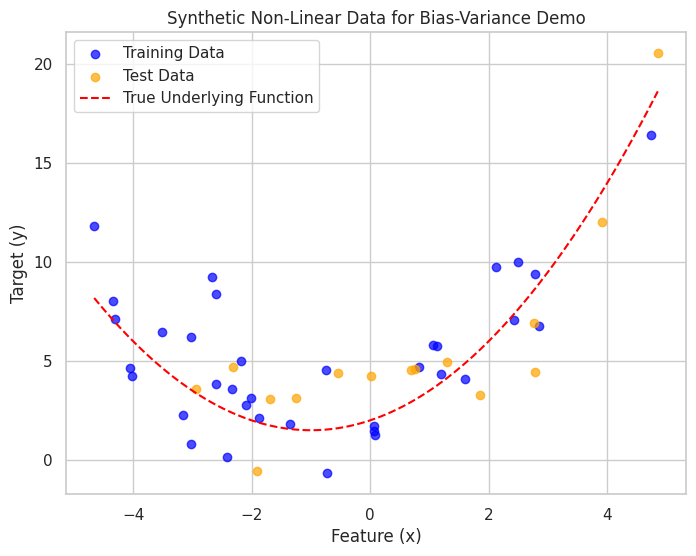

In [121]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_bv.numpy(), y_train_bv.numpy(), label='Training Data', alpha=0.7, color='blue')
plt.scatter(X_test_bv.numpy(), y_test_bv.numpy(), label='Test Data', alpha=0.7, color='orange')
plt.plot(X_plot_smooth_np, y_plot_smooth_true_np, color='red', linestyle='--', label='True Underlying Function')
plt.xlabel("Feature (x)"); 
plt.ylabel("Target (y)")
plt.title("Synthetic Non-Linear Data for Bias-Variance Demo"); 
plt.legend(); 
plt.show()

In [122]:
# Train polynomial regression model
def train(x, y, degree, num_epochs=1000, lr=0.01, verbose=False):
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_np = poly_transformer.fit_transform(x.numpy())

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X_poly_np)
    x_scaled_tensor = torch.from_numpy(x_scaled).float()

    n_poly_features = x_scaled_tensor.shape[1]

    model = nn.Linear(n_poly_features, 1)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    if verbose: 
        print(f"Training Polynomial Degree {degree} with {n_poly_features} features...")

    loss_history = []
    for epoch in range(num_epochs):
        # forward pass
        y_pred = model(x_scaled_tensor)
        # compute loss
        loss = criterion(y_pred, y)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        if verbose and (epoch + 1) % (num_epochs // 5) == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model, poly_transformer, scaler, loss_history

In [123]:
def predict(model, x, poly_transformer, scaler):
    """Makes predictions using the trained polynomial model."""
    X_poly_np = poly_transformer.transform(x.numpy())
    X_poly_scaled_np = scaler.transform(X_poly_np)
    X_poly_scaled_tensor = torch.from_numpy(X_poly_scaled_np).float()
    with torch.no_grad():
        predictions = model(X_poly_scaled_tensor)
    return predictions

### Underfitting (High Bias)
<p>A model that is too simple to capture the underlying trend in the data</p>

In [124]:
degree_underfit = 1
model_underfit, poly_underfit, scaler_underfit, loss_hist_underfit = train(
    X_train_bv, y_train_bv, degree=degree_underfit, num_epochs=500, lr=0.01, verbose=True
)

Training Polynomial Degree 1 with 1 features...
  Epoch [100/500], Loss: 35.9925
  Epoch [200/500], Loss: 35.9925
  Epoch [300/500], Loss: 35.9925
  Epoch [400/500], Loss: 35.9925
  Epoch [500/500], Loss: 35.9925


In [125]:
y_plot_pred_underfit = predict(model_underfit, X_plot_smooth_tensor, poly_underfit, scaler_underfit)
y_train_pred_underfit = predict(model_underfit, X_train_bv, poly_underfit, scaler_underfit)
y_test_pred_underfit = predict(model_underfit, X_test_bv, poly_underfit, scaler_underfit)

In [126]:
mse_train_underfit = mean_squared_error(y_train_bv, y_train_pred_underfit)
mse_test_underfit = mean_squared_error(y_test_bv, y_test_pred_underfit)

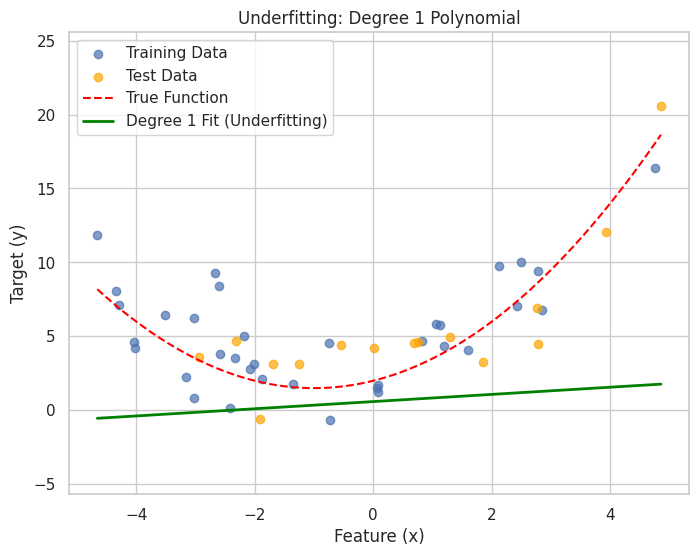

In [127]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_bv.numpy(), y_train_bv.numpy(), label='Training Data', alpha=0.7)
plt.scatter(X_test_bv.numpy(), y_test_bv.numpy(), label='Test Data', alpha=0.7, color='orange')
plt.plot(X_plot_smooth_np, y_plot_smooth_true_np, color='red', linestyle='--', label='True Function')
plt.plot(X_plot_smooth_np, y_plot_pred_underfit.numpy(), color='green', linewidth=2, label=f'Degree {degree_underfit} Fit (Underfitting)')
plt.xlabel("Feature (x)"); 
plt.ylabel("Target (y)")
plt.title(f"Underfitting: Degree {degree_underfit} Polynomial")
plt.legend(); 
plt.ylim(y_bv_tensor.min()-5, y_bv_tensor.max()+5); 
plt.show()

### Overfitting (High Variance)
<p>A model that is too complex and learns the noise in the training data, rather than the underlying trend. It performs well on training data but poorly on test data.</p>

In [128]:
degree_overfit = 15     # high degree for small dataset
model_overfit, poly_overfit, scaler_overfit, loss_hist_overfit = train(
    X_train_bv, y_train_bv, degree=degree_overfit, num_epochs=10000, lr=0.005, verbose=False # May need more epochs and smaller LR
)

In [129]:
if loss_hist_overfit: print(f"Degree {degree_overfit} - Final Training Loss: {loss_hist_overfit[-1]:.4f}")

Degree 15 - Final Training Loss: 42.6990


In [130]:
y_plot_pred_overfit = predict(model_overfit, X_plot_smooth_tensor, poly_overfit, scaler_overfit)
y_train_pred_overfit = predict(model_overfit, X_train_bv, poly_overfit, scaler_overfit)
y_test_pred_overfit = predict(model_overfit, X_test_bv, poly_overfit, scaler_overfit)

In [131]:
mse_train_overfit = mean_squared_error(y_train_bv, y_train_pred_overfit)
mse_test_overfit = mean_squared_error(y_test_bv, y_test_pred_overfit)

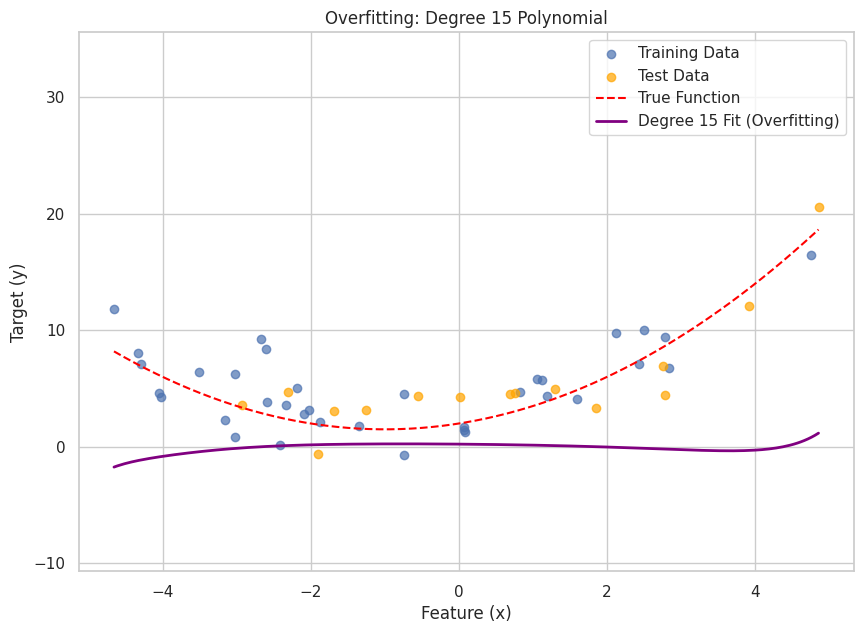

In [132]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train_bv.numpy(), y_train_bv.numpy(), label='Training Data', alpha=0.7)
plt.scatter(X_test_bv.numpy(), y_test_bv.numpy(), label='Test Data', alpha=0.7, color='orange')
plt.plot(X_plot_smooth_np, y_plot_smooth_true_np, color='red', linestyle='--', label='True Function')
plt.plot(X_plot_smooth_np, y_plot_pred_overfit.numpy(), color='purple', linewidth=2, label=f'Degree {degree_overfit} Fit (Overfitting)')
plt.xlabel("Feature (x)"); plt.ylabel("Target (y)")
plt.title(f"Overfitting: Degree {degree_overfit} Polynomial")
plt.legend(); 
plt.ylim(y_bv_tensor.min()-10, y_bv_tensor.max()+15); 
plt.show()